## Modeling Questions


* Calc AUC score to all models
* Save all charts to a folder

### With more time
* I SHOULD consider only doing features available to my predicted audience (no drinking/drugs).
* SMOAT Upsample and try running all models on that data.
  * **train_test_split STRATIFIED before SMOTE, then only SMOTE the train set?**
  * do new .ipynb doing SMOTE and sampling!

## F1 score algebraic derivation

Dana and I derived the following score. If D is the proportion of UNSUCCESSES or NOs in the Ground Truth, then a "monkey predicted" F1 Score, aka if a coin flip was used to categorize the info and split evenly by
how many Ground Truths there are, then: 

$$D=\frac{1-D}{1.5-D}$$

#### KNN
* Lazy
* Fits **fast**, predicts **slow**
* Fits d-dimensional data in `O(dn)` time
* Higher memory (saves entire data set)
* Various implementations (weighted, uniform)


In [73]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as st
# import pymc3 as pm
import seaborn as sns

# enables inline plots, without it plots don't show up in the notebook
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
# %config InlineBackend.figure_format = 'png'
# mpl.rcParams['figure.dpi']= 300

pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 60)
pd.set_option('display.precision', 3)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import sklearn
from sklearn.preprocessing import StandardScaler, Binarizer, LabelBinarizer, MultiLabelBinarizer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, cross_validate \
                                    ,cross_val_predict, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix,recall_score,precision_score, f1_score
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

from sklearn.metrics import roc_curve, auc

import itertools
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib
from imblearn.over_sampling import SMOTE

# Helper Functions

In [74]:
target_names=['No','Yes']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def confusion_matrices(y_pred):
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)
    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=target_names,
                          title='Confusion matrix, without normalization')
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=target_names, normalize=True,
                          title='Confusion matrix, Normalized')

In [75]:
def plot_roc_curve(fit_model, title):
    y_score=fit_model.predict_proba(X_test)[:,1]
    fpr, tpr,_ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,6))
    # Plotting the Baseline
    plt.plot([0,1],[0,1])
    plt.plot(fpr,tpr)
    plt.grid(which='major')
    plt.title(f"{title} ROC curve")
    s= 'AUC: ' + str(round(metrics.roc_auc_score(y_test, fit_model.predict(X_test)),3))
    plt.text(0.75, 0.25, s=s, ha='right', va='bottom', fontsize=14,
             bbox=dict(facecolor='grey', alpha=0.5))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate');

In [76]:
def makecost(obs,prob,falsepos_cost,falseneg_cost):
    def cost(cutoff):
        pred = np.array(prob > cutoff)
        fpos = pred * (1 - obs) 
        fneg = (1 - pred) * obs
        return np.sum(fpos * falsepos_cost + fneg * falseneg_cost)
    return np.vectorize(cost)

# cut = np.linspace(0,1,100)
# cost = np.zeros_like(cut)
# from sklearn.model_selection import KFold, cross_val_predict
# obs = np.ravel(y)

# K = 20
# for j in range(K):
#     folds = KFold(n_splits=5,shuffle=True)
#     prob = cross_val_predict(logreg,X,np.ravel(y),cv=folds,method='predict_proba',n_jobs=5)[:,1]
#     getcost = makecost(obs,prob,falsepos_cost=20,falseneg_cost=25)
#     currentcost = getcost(cut)/X.shape[0]
#     cost += currentcost
#     plt.plot(cut, currentcost,c='C0',alpha=0.05)
# cost /= K
# plt.plot(cut,cost,c='C0')
# plt.xlabel('cutoff')
# plt.ylabel('Expected cost per data point');

In [77]:
def number_of_uniques(df):
    for i in df.columns:
        print(i,":", len(df[i].unique()))
        
def number_of_NaN(df):
    for i in df.columns:
        if df[i].isna().sum() != 0:
            print(i,":", df[i].isna().sum())

# Load Data

In [176]:
cupid = pd.read_hdf('data/cupid_cleaned.hd5', key='df', mode='r')
#cupid = load_pd_pkl('data/cupid_cleaned')

In [177]:
# Create binary "wants_kids" YES vs NO from the more options
cupid['wants_kids_binary'] = ['yes' if x == 'yes' else 'no' if x == 'no' else np.nan for x in cupid['wants_kids']]
cupid['has_kids_options'] = ['one' if x == 'one' else 'multiple' if x == 'multiple' else 'no' if x == 'no' else np.nan for x in cupid['has_kids']]

cupid['status_available'] =  ['yes' if x == 'available' else 'yes' if x == 'single' else np.nan for x in cupid['status']]

In [178]:
target = ['wants_kids_binary']
continuous = ['age'] #, 'height']
# bi_categorical = ['sex', 'signs_fun', 'signs_unimportant', 'signs_important',
#                      'religion_unserious', 'religion_laughing', 'religion_somewhat',
#                      'religion_serious', ]
# mult_categorical = ['body_type', 'drinks', 'drugs', 'income', 'orientation', 'status',
#                       'diet_intensity', 'diet_choice', 'primary_ethnicity',
#                       'has_kids','likes_cats', 'likes_dogs', 'dislikes_cats', 'dislikes_dogs',
#                       'has_cats', 'has_dogs','english_fluent','english_poor','spanish_fluent',
#                       'spanish_not_poorly','religion_name','new_education',]



# remove from bi: 'signs_fun', 'signs_unimportant', 'signs_important', 'religion_unserious', 'religion_laughing', 'religion_somewhat',
#                     'religion_serious',

bi_categorical = ['sex', 'signs_fun', 'signs_unimportant', 'signs_important', 
                  'religion_unserious', 'religion_laughing', 'religion_somewhat', 'religion_serious']


# remove from multi:  'new_education','likes_cats', 'likes_dogs', 'dislikes_cats', 
#          'dislikes_dogs', 'has_cats', 'has_dogs', 'primary_ethnicity', , 
#          'english_fluent','english_poor','spanish_fluent','spanish_not_poorly',
#          'diet_intensity', 'diet_choice', 'religion_name'
                      
mult_categorical = ['orientation', 'status_available',
                      'drinks', 'smokes', 'drugs', 'religion_name',]


# Assign feature groupings
columns = bi_categorical + mult_categorical + target

# Create DF of everything
df = cupid[target + continuous + bi_categorical + mult_categorical]

### Change data type of age
df['age'] = df.age.astype(float)

df = df.dropna()

# Split DF of only standardized/scaled features
scaled_features = df.copy().loc[:, continuous]

# Tranform age and height (standardized features)
features = scaled_features[continuous]
features = StandardScaler().fit_transform(features.values)
scaled_features[continuous] = features

# Create dummy variables for original features, then combine back with scaled features
dummies = pd.get_dummies(df.loc[:, columns], columns=columns, drop_first=False)
df = scaled_features.join(dummies)

# Drop all "placeholder" columns
df.drop(df.filter(regex='placeholder'), axis=1, inplace=True)


# Drop unused binary column
df.drop(columns=['status_available_yes', 'wants_kids_binary_no', 'sex_f','signs_important_matters a lot',
                 'religion_serious_very serious','orientation_straight','drinks_very often','smokes_yes',
                 'drugs_often','religion_name_other'], axis=1, inplace=True)


# SETUP MODELING DATA

X = df.drop('wants_kids_binary_yes', axis=1)
y = df['wants_kids_binary_yes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

/home/spencer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [179]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_sample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train==0)))

Before OverSampling, counts of label '1': 1375
Before OverSampling, counts of label '0': 1880 

After OverSampling, the shape of train_X: (3760, 28)
After OverSampling, the shape of train_y: (3760,) 

After OverSampling, counts of label '1': 1880
After OverSampling, counts of label '0': 1880


In [180]:
cupid.has_kids.value_counts().sum()

24385

In [181]:
X_train.shape

(3760, 28)

# K-Nearest Neighbors (KNN)

In [85]:
55697 + 1865

57562

In [91]:
knn = KNeighborsClassifier()

# define the parameter values that should be searched
#k_range = list(range(1, 7))
#weight_options = ['uniform', 'distance']

k_range = list(range(1,80))
# weight_options = ['uniform']
weight_options = ['uniform', 'distance']

# create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(n_neighbors=k_range, weights=weight_options)
# print(param_grid)

# instantiate the grid
grid_knn = RandomizedSearchCV(knn, param_grid, cv=10, scoring='roc_auc', n_jobs=-1, n_iter=100)

# fit the grid with data
grid_knn.fit(X_train, y_train)

# examine the best model
print(grid_knn.best_score_)
print(grid_knn.best_params_)
print(grid_knn.best_estimator_)

0.859225045269
{'weights': 'uniform', 'n_neighbors': 77}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=77, p=2,
           weights='uniform')


In [86]:
cupid.status.value_counts()

single            55697
seeing someone     2064
available          1865
married             310
unknown              10
Name: status, dtype: int64

In [93]:
dir = 'AUC_no_kids_SMOTE_reduced_features_models'

In [94]:
joblib.dump(grid_knn, f'{dir}/knn.joblib')  # Save model to disk

['AUC_no_kids_SMOTE_reduced_features_models/knn.joblib']

In [95]:
y_pred_knn = grid_knn.predict(X_test)
print("test f1:", metrics.f1_score(y_test, y_pred_knn))
print("test accuracy:", metrics.accuracy_score(y_test, y_pred_knn))
print("roc_auc:", metrics.roc_auc_score(y_test, y_pred_knn))

test f1: 0.738216098622
test accuracy: 0.741218637993
roc_auc: 0.757770667363


In [96]:
print('AUC:', round(metrics.roc_auc_score(y_test, y_pred_knn),3))

AUC: 0.758


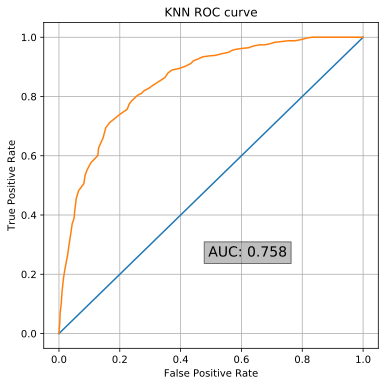

In [97]:
plot_roc_curve(grid_knn, 'KNN')

classification report: 

              precision    recall  f1-score   support

          No       0.87      0.65      0.74       806
         Yes       0.64      0.86      0.74       589

   micro avg       0.74      0.74      0.74      1395
   macro avg       0.76      0.76      0.74      1395
weighted avg       0.77      0.74      0.74      1395

Confusion matrix, without normalization
[[525 281]
 [ 80 509]]
Normalized confusion matrix
[[ 0.65  0.35]
 [ 0.14  0.86]]


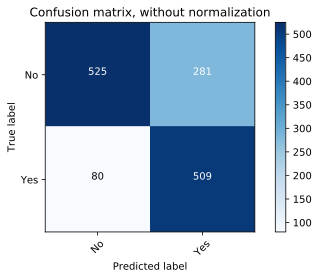

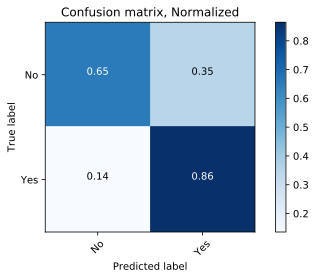

In [98]:
print("classification report: \n")
print(metrics.classification_report(y_test, y_pred_knn,target_names=target_names ))
confusion_matrices(y_pred_knn)

### Now messing with THRESHOLD

In [99]:
y_prob = grid_knn.predict_proba(X_test)

y_pred_knn_prob = y_prob[:,1] >= 0.7

print(metrics.classification_report(y_test, y_pred_knn_prob, target_names=target_names))
print("accuracy: ", metrics.accuracy_score(y_test, y_pred_knn_prob))

              precision    recall  f1-score   support

          No       0.76      0.87      0.81       806
         Yes       0.78      0.63      0.69       589

   micro avg       0.77      0.77      0.77      1395
   macro avg       0.77      0.75      0.75      1395
weighted avg       0.77      0.77      0.76      1395

accuracy:  0.767025089606


Confusion matrix, without normalization
[[701 105]
 [220 369]]
Normalized confusion matrix
[[ 0.87  0.13]
 [ 0.37  0.63]]


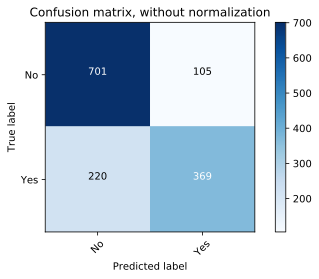

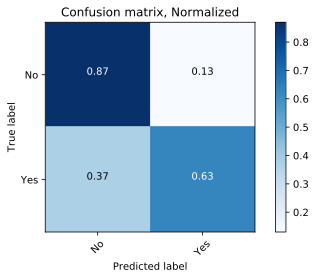

In [100]:
confusion_matrices(y_pred_knn_prob)

# Logistic Regression

In [101]:
logreg = LogisticRegression(max_iter=500, random_state=42)
# define the parameter values that should be searched
C_options = [0.5, 1, 2, 3]
duals = [False]
tol_options = [1e-3, 1e-2, 1e-1]
pen_options = ['l2']
solver_options = ['liblinear', 'sag', 'newton-cg', 'lbfgs']

# create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(C=C_options, dual=duals, tol=tol_options, penalty=pen_options, solver=solver_options)
# print(param_grid)

# instantiate the grid
grid_lr = RandomizedSearchCV(logreg, param_grid, cv=10, scoring='roc_auc', n_jobs=6, n_iter=60)

# fit the grid with data
grid_lr.fit(X_train, y_train);

# examine the best model
print(grid_lr.best_score_)
print(grid_lr.best_params_)
print(grid_lr.best_estimator_)

/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 48 is smaller than n_iter=60. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


0.841711464464
{'tol': 0.1, 'solver': 'sag', 'penalty': 'l2', 'dual': False, 'C': 2}
LogisticRegression(C=2, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=500, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='sag',
          tol=0.1, verbose=0, warm_start=False)


In [102]:
grid_lr = grid_lr.best_estimator_

In [103]:
joblib.dump(grid_lr, f'{dir}/logreg.joblib')  # Save model to disk

['AUC_no_kids_SMOTE_reduced_features_models/logreg.joblib']

In [104]:
y_pred_logreg = grid_lr.predict(X_test)
print(metrics.roc_auc_score(y_test, y_pred_logreg))

print(metrics.classification_report(y_test, grid_lr.predict(X_test)))


0.758750163249
              precision    recall  f1-score   support

           0       0.82      0.74      0.78       806
           1       0.69      0.78      0.73       589

   micro avg       0.76      0.76      0.76      1395
   macro avg       0.75      0.76      0.75      1395
weighted avg       0.76      0.76      0.76      1395



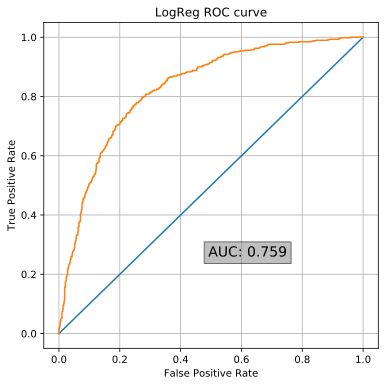

In [105]:
plot_roc_curve(grid_lr, "LogReg")

Confusion matrix, without normalization
[[595 211]
 [130 459]]
Normalized confusion matrix
[[ 0.74  0.26]
 [ 0.22  0.78]]


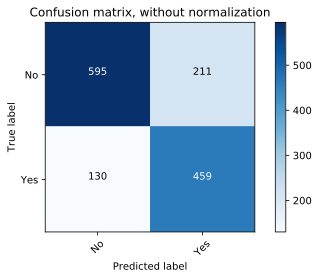

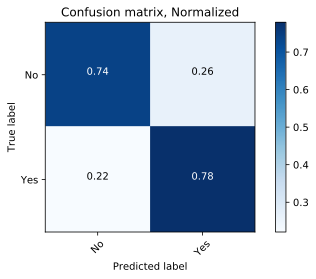

In [106]:
confusion_matrices(y_pred_logreg)

### Now messing with THRESHOLD

In [107]:
y_prob = grid_lr.predict_proba(X_test)

y_pred_lr_prob = y_prob[:,1] >= 0.4

print(metrics.classification_report(y_test, y_pred_lr_prob, target_names=target_names))
print("accuracy: ", metrics.accuracy_score(y_test, y_pred_lr_prob))

              precision    recall  f1-score   support

          No       0.85      0.66      0.74       806
         Yes       0.64      0.84      0.73       589

   micro avg       0.73      0.73      0.73      1395
   macro avg       0.75      0.75      0.73      1395
weighted avg       0.76      0.73      0.73      1395

accuracy:  0.734050179211


Confusion matrix, without normalization
[[528 278]
 [ 93 496]]
Normalized confusion matrix
[[ 0.66  0.34]
 [ 0.16  0.84]]


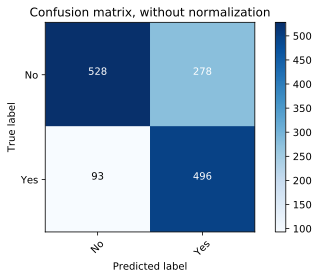

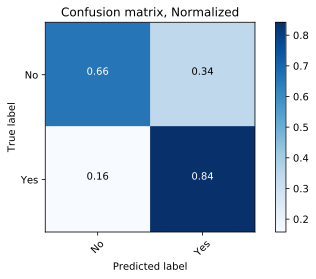

In [108]:
confusion_matrices(y_pred_lr_prob)

# Support Vector Machine (SVM)

In [110]:
svm = SVC(probability = True, random_state=42)

Cs=[0.5, 1, 1.5]
kernels = ['rbf', 'sigmoid', 'linear']
gammas = ['scale', 'auto']
tols = [1e-5, 1e-4, 1e-3, 1e-2]

# Cs=[.75, 1, 1.25, 1.5, 2]
# kernels = ['linear','rbf','sigmoid']
# gammas = ['scale', 'auto']
# tols = [.00001, .0001, .001, .01,]

param_grid = dict(C=Cs, tol=tols, gamma=gammas, kernel=kernels)

grid_svm = RandomizedSearchCV(svm, param_grid, cv=10, scoring='roc_auc', n_jobs=-1, n_iter=30)

grid_svm.fit(X_train, y_train)

print(grid_svm.best_score_)
print(grid_svm.best_params_)
print(grid_svm.best_estimator_)

0.88006309416
{'tol': 0.001, 'kernel': 'rbf', 'gamma': 'scale', 'C': 1.5}
SVC(C=1.5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False)


In [111]:
grid_svm = grid_svm.best_estimator_

In [112]:
y_pred_best_svm = grid_svm.predict(X_test)
print(metrics.roc_auc_score(y_test, y_pred_best_svm))
print(metrics.classification_report(y_test, y_pred_best_svm))

0.765410735275
              precision    recall  f1-score   support

           0       0.81      0.78      0.80       806
           1       0.71      0.75      0.73       589

   micro avg       0.77      0.77      0.77      1395
   macro avg       0.76      0.77      0.76      1395
weighted avg       0.77      0.77      0.77      1395



In [113]:
metrics.accuracy_score(y_test, y_pred_best_svm)

0.76774193548387093

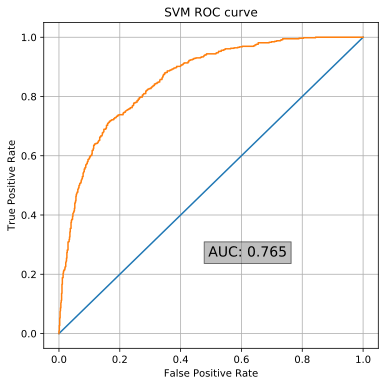

In [114]:
plot_roc_curve(grid_svm, 'SVM')

In [115]:
joblib.dump(grid_svm, f'{dir}/SVM.joblib')  # Save model to disk

['AUC_no_kids_SMOTE_reduced_features_models/SVM.joblib']

Confusion matrix, without normalization
[[629 177]
 [147 442]]
Normalized confusion matrix
[[ 0.78  0.22]
 [ 0.25  0.75]]


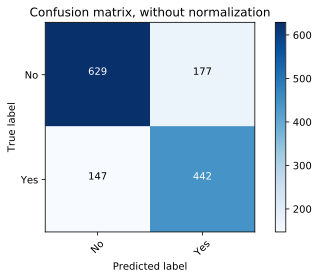

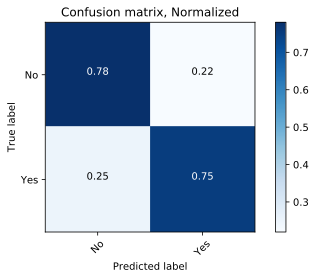

In [116]:
confusion_matrices(y_pred_best_svm)

### Now messing with THRESHOLD

In [117]:
y_prob = grid_svm.predict_proba(X_test)

y_pred_svm_prob = y_prob[:,1] > 0.4

print(metrics.classification_report(y_test, y_pred_svm_prob, target_names=target_names))
print("accuracy: ", metrics.accuracy_score(y_test, y_pred_svm_prob))

              precision    recall  f1-score   support

          No       0.84      0.72      0.78       806
         Yes       0.68      0.81      0.74       589

   micro avg       0.76      0.76      0.76      1395
   macro avg       0.76      0.77      0.76      1395
weighted avg       0.77      0.76      0.76      1395

accuracy:  0.758422939068


Confusion matrix, without normalization
[[581 225]
 [112 477]]
Normalized confusion matrix
[[ 0.72  0.28]
 [ 0.19  0.81]]


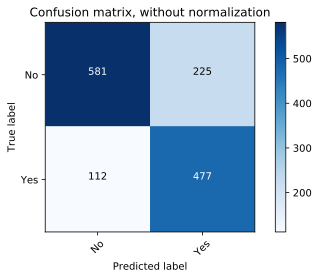

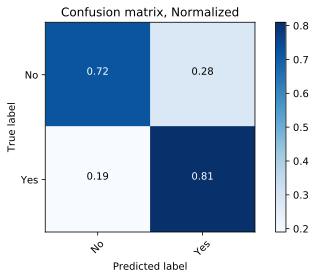

In [118]:
confusion_matrices(y_pred_svm_prob)

# Decision Trees

In [119]:
dt = DecisionTreeClassifier(random_state=42)

criterions = ['gini', 'entropy']    

param_grid = dict(criterion=criterions)

grid_dt = GridSearchCV(dt, param_grid, scoring='roc_auc', cv=10, n_jobs=-1)

grid_dt.fit(X_train, y_train)

print(grid_dt.best_score_)
print(grid_dt.best_params_)
print(grid_dt.best_estimator_)

0.749547306474
{'criterion': 'entropy'}
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')


In [120]:
grid_dt = grid_dt.best_estimator_

In [121]:
joblib.dump(grid_dt, f'{dir}/DecisionTree.joblib')  # Save model to disk

['AUC_no_kids_SMOTE_reduced_features_models/DecisionTree.joblib']

In [122]:
y_pred_dtree = grid_dt.predict(X_test)

print(metrics.classification_report(y_test, y_pred_dtree))
print('accuracy:', metrics.accuracy_score(y_test, y_pred_dtree))

              precision    recall  f1-score   support

           0       0.77      0.78      0.77       806
           1       0.69      0.68      0.68       589

   micro avg       0.73      0.73      0.73      1395
   macro avg       0.73      0.73      0.73      1395
weighted avg       0.73      0.73      0.73      1395

accuracy: 0.73476702509


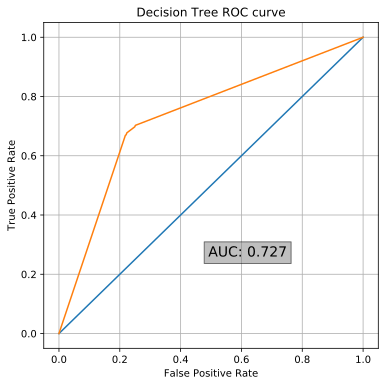

In [123]:
plot_roc_curve(grid_dt, "Decision Tree")

Confusion matrix, without normalization
[[626 180]
 [190 399]]
Normalized confusion matrix
[[ 0.78  0.22]
 [ 0.32  0.68]]


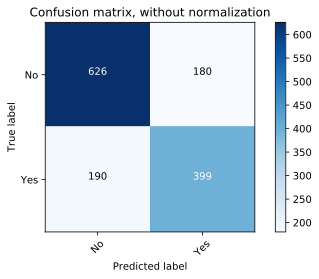

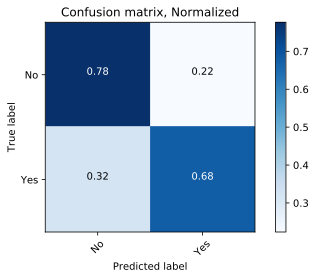

In [124]:
confusion_matrices(y_pred_dtree)

### Now messing with THRESHOLD - Nothing in Decision Tree matters.

In [125]:
y_prob = grid_dt.predict_proba(X_test)

y_pred_dt_prob = y_prob[:,1] > 0.5

print(metrics.classification_report(y_test, y_pred_dt_prob, target_names=target_names))
print("accuracy: ", metrics.accuracy_score(y_test, y_pred_dt_prob))

              precision    recall  f1-score   support

          No       0.77      0.78      0.77       806
         Yes       0.69      0.68      0.68       589

   micro avg       0.73      0.73      0.73      1395
   macro avg       0.73      0.73      0.73      1395
weighted avg       0.73      0.73      0.73      1395

accuracy:  0.73476702509


Confusion matrix, without normalization
[[626 180]
 [190 399]]
Normalized confusion matrix
[[ 0.78  0.22]
 [ 0.32  0.68]]


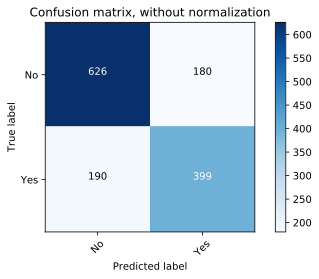

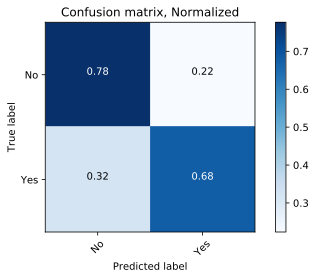

In [126]:
confusion_matrices(y_pred_dt_prob)

# Random Forrest

In [127]:
rf = RandomForestClassifier(random_state=42)

criterions = ['gini', 'entropy']
n_ests = [100, 300]
    
param_grid = dict(criterion=criterions, n_estimators=n_ests)

grid_rf = GridSearchCV(rf, param_grid, scoring='roc_auc', cv=10, n_jobs=-1)

grid_rf.fit(X_train, y_train)

print(grid_rf.best_score_)
print(grid_rf.best_params_)
print(grid_rf.best_estimator_)

0.873892315527
{'criterion': 'gini', 'n_estimators': 300}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)


In [128]:
grid_rf = grid_rf.best_estimator_

In [129]:
joblib.dump(grid_rf, f'{dir}/RandomForest.joblib')  # Save model to disk

['AUC_no_kids_SMOTE_reduced_features_models/RandomForest.joblib']

In [130]:
y_pred_rf = grid_rf.predict(X_test)

print(metrics.classification_report(y_test, y_pred_rf))
print('accuracy:', metrics.accuracy_score(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.79      0.83      0.81       806
           1       0.75      0.69      0.72       589

   micro avg       0.77      0.77      0.77      1395
   macro avg       0.77      0.76      0.76      1395
weighted avg       0.77      0.77      0.77      1395

accuracy: 0.772759856631


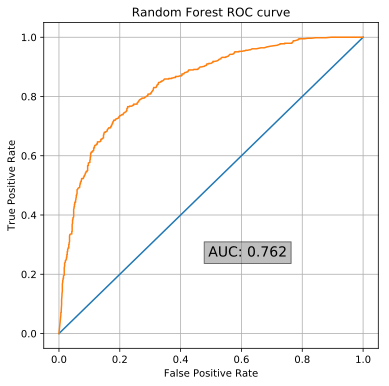

In [131]:
plot_roc_curve(grid_rf, "Random Forest")

Confusion matrix, without normalization
[[669 137]
 [180 409]]
Normalized confusion matrix
[[ 0.83  0.17]
 [ 0.31  0.69]]


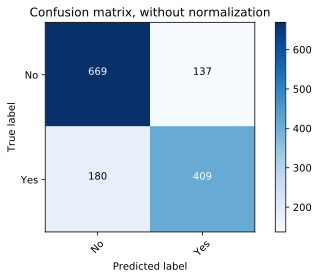

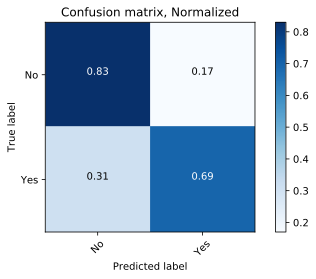

In [132]:
confusion_matrices(y_pred_rf)

### Now messing with THRESHOLD

In [133]:
y_prob = grid_rf.predict_proba(X_test)

y_pred_rf_prob = y_prob[:,1] > 0.35

print(metrics.classification_report(y_test, y_pred_rf_prob, target_names=target_names))
print("accuracy: ", metrics.accuracy_score(y_test, y_pred_rf_prob))

              precision    recall  f1-score   support

          No       0.83      0.72      0.77       806
         Yes       0.67      0.80      0.73       589

   micro avg       0.75      0.75      0.75      1395
   macro avg       0.75      0.76      0.75      1395
weighted avg       0.76      0.75      0.75      1395

accuracy:  0.750537634409


Confusion matrix, without normalization
[[577 229]
 [119 470]]
Normalized confusion matrix
[[ 0.72  0.28]
 [ 0.2   0.8 ]]


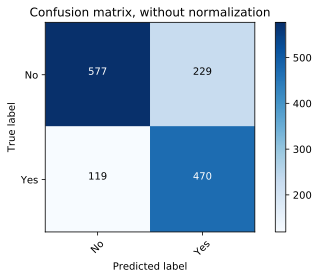

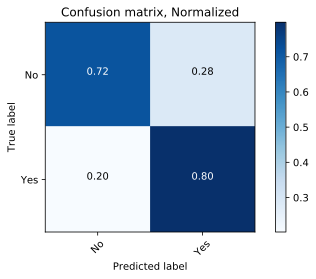

In [134]:
confusion_matrices(y_pred_rf_prob)

# Gradient Boosting

In [135]:
gb = GradientBoostingClassifier(random_state=42)

losses = ['deviance', 'exponential']
lrs = [.01, .05, .1, .5, 1]
n_ests = [50, 100, 200]
subsamples=[0.5, .75, 1]
maxd = [3,5]
tols = [1e-6, 1e-5, 1e-4, 1e-3]
    
    

param_grid = dict(loss=losses, learning_rate=lrs, n_estimators=n_ests, subsample=subsamples,
                 max_depth=maxd, tol=tols)

grid_gb = RandomizedSearchCV(gb, param_grid, scoring='roc_auc', cv=10, n_jobs=-1, n_iter=100)

grid_gb.fit(X_train, y_train)

print(grid_gb.best_score_)
print(grid_gb.best_params_)
print(grid_gb.best_estimator_)

0.896825486646
{'tol': 1e-05, 'subsample': 0.75, 'n_estimators': 200, 'max_depth': 3, 'loss': 'deviance', 'learning_rate': 0.1}
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              n_iter_no_change=None, presort='auto', random_state=42,
              subsample=0.75, tol=1e-05, validation_fraction=0.1,
              verbose=0, warm_start=False)


In [136]:
grid_gb = grid_gb.best_estimator_
grid_gb

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              n_iter_no_change=None, presort='auto', random_state=42,
              subsample=0.75, tol=1e-05, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [175]:
grid_gb.oob_improvement_

array([  6.02e-02,   4.98e-02,   4.20e-02,   3.73e-02,   2.81e-02,
         2.34e-02,   1.99e-02,   2.13e-02,   2.00e-02,   1.45e-02,
         1.34e-02,   9.84e-03,   1.23e-02,   9.64e-03,   1.00e-02,
         7.57e-03,   8.74e-03,   6.94e-03,   3.76e-03,   6.08e-03,
         8.40e-03,   6.58e-03,   4.85e-03,   4.37e-03,   2.72e-03,
         3.26e-03,   3.12e-03,   3.49e-03,   3.50e-03,   2.84e-03,
         3.80e-03,   1.78e-03,   1.83e-03,   7.71e-04,   3.55e-03,
         1.50e-03,   5.99e-04,   1.96e-03,   1.10e-03,   1.17e-03,
         6.92e-04,  -1.94e-04,   9.83e-04,   2.26e-03,  -5.99e-05,
         3.46e-04,   1.48e-03,   7.18e-06,   1.34e-03,   2.73e-04,
         4.17e-04,   1.22e-03,   7.30e-04,   1.38e-03,   1.85e-04,
         2.42e-04,   1.46e-03,   7.66e-04,   2.79e-04,   1.25e-04,
        -6.36e-04,   6.02e-05,  -4.35e-04,  -1.25e-04,   4.08e-05,
         4.35e-04,  -1.11e-04,  -1.07e-03,   1.05e-04,  -1.68e-04,
        -6.11e-04,  -5.20e-05,  -3.72e-04,   6.29e-04,   4.61e

In [137]:
joblib.dump(grid_gb, f'{dir}/GradientBoosting_reducedfeatures.joblib')  # Save model to disk

['AUC_no_kids_SMOTE_reduced_features_models/GradientBoosting_reducedfeatures.joblib']

In [138]:
y_pred_gb = grid_gb.predict(X_test)

metrics.roc_auc_score(y_test, y_pred_gb)

0.77380175003264995

In [139]:
print(metrics.classification_report(y_test, y_pred_gb))

              precision    recall  f1-score   support

           0       0.81      0.80      0.81       806
           1       0.73      0.74      0.74       589

   micro avg       0.78      0.78      0.78      1395
   macro avg       0.77      0.77      0.77      1395
weighted avg       0.78      0.78      0.78      1395



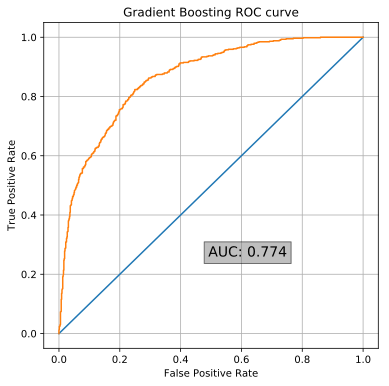

In [140]:
plot_roc_curve(grid_gb, "Gradient Boosting")

Confusion matrix, without normalization
[[648 158]
 [151 438]]
Normalized confusion matrix
[[ 0.8   0.2 ]
 [ 0.26  0.74]]


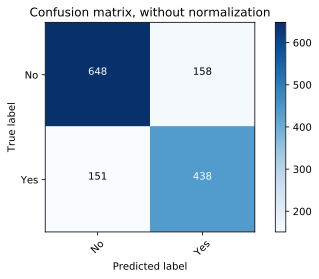

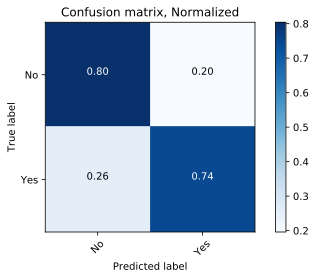

In [141]:
confusion_matrices(y_pred_gb)

### Now messing with THRESHOLD

In [142]:
y_prob = grid_gb.predict_proba(X_test)

y_pred_gb_prob = y_prob[:,1] > 0.5

print(metrics.classification_report(y_test, y_pred_gb_prob, target_names=target_names))
print("accuracy: ", metrics.accuracy_score(y_test, y_pred_gb_prob))

              precision    recall  f1-score   support

          No       0.81      0.80      0.81       806
         Yes       0.73      0.74      0.74       589

   micro avg       0.78      0.78      0.78      1395
   macro avg       0.77      0.77      0.77      1395
weighted avg       0.78      0.78      0.78      1395

accuracy:  0.778494623656


Confusion matrix, without normalization
[[648 158]
 [151 438]]
Normalized confusion matrix
[[ 0.8   0.2 ]
 [ 0.26  0.74]]


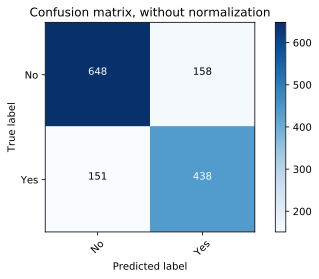

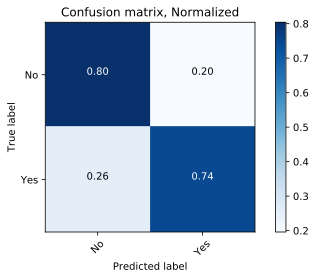

In [143]:
confusion_matrices(y_pred_gb_prob)

# Naive Bayes

In [144]:
bern = BernoulliNB()
bern.fit(X_train, y_train)
y_pred_bern = bern.predict(X_test)
metrics.roc_auc_score(y_test, y_pred_bern)

0.70331069609507646

In [145]:
nb = GaussianNB()

nb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [146]:
joblib.dump(nb, f'{dir}/NaiveBayesGaussian.joblib')  # Save model to disk

['AUC_no_kids_SMOTE_reduced_features_models/NaiveBayesGaussian.joblib']

In [147]:
y_pred_nb = nb.predict(X_test)

In [148]:
metrics.roc_auc_score(y_test, y_pred_nb)

0.72724304557920849

In [149]:
print(metrics.classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

           0       0.78      0.73      0.76       806
           1       0.66      0.72      0.69       589

   micro avg       0.73      0.73      0.73      1395
   macro avg       0.72      0.73      0.72      1395
weighted avg       0.73      0.73      0.73      1395



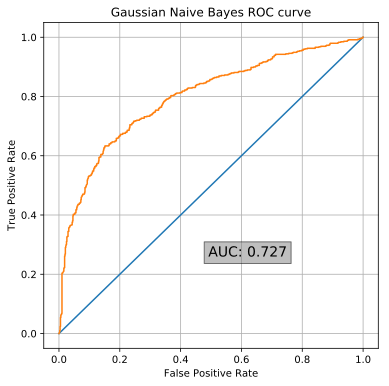

In [150]:
plot_roc_curve(nb, "Gaussian Naive Bayes")

Confusion matrix, without normalization
[[588 218]
 [162 427]]
Normalized confusion matrix
[[ 0.73  0.27]
 [ 0.28  0.72]]


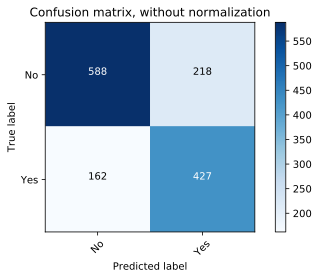

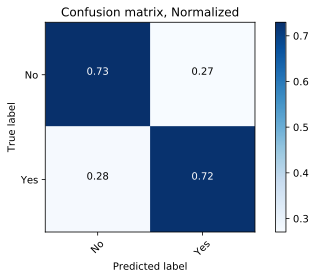

In [151]:
confusion_matrices(y_pred_nb)

### Now messing with THRESHOLD

In [152]:
y_prob = nb.predict_proba(X_test)

y_pred_nb_prob = y_prob[:,1] > 0.5

print(metrics.classification_report(y_test, y_pred_nb_prob, target_names=target_names))
print("accuracy: ", metrics.accuracy_score(y_test, y_pred_nb_prob))

              precision    recall  f1-score   support

          No       0.78      0.73      0.76       806
         Yes       0.66      0.72      0.69       589

   micro avg       0.73      0.73      0.73      1395
   macro avg       0.72      0.73      0.72      1395
weighted avg       0.73      0.73      0.73      1395

accuracy:  0.727598566308


Confusion matrix, without normalization
[[588 218]
 [162 427]]
Normalized confusion matrix
[[ 0.73  0.27]
 [ 0.28  0.72]]


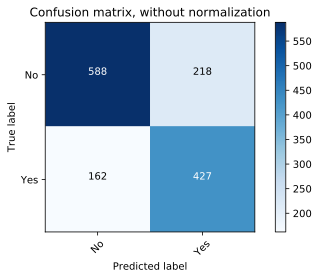

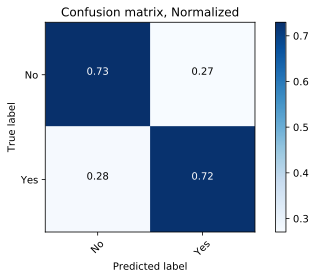

In [153]:
confusion_matrices(y_pred_nb_prob)

NameError: name 'new_x' is not defined

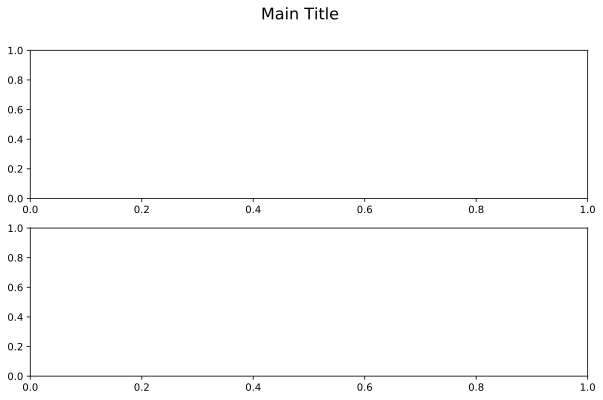

In [154]:
fig, ax = plt.subplots(2, 1, figsize=(10, 4))
fig.set_figwidth(10)
fig.set_figheight(6)

fig.suptitle('Main Title',fontsize = 16)

ax[0].plot(new_x,new_y)
ax[0].set_title('Line Chart')

ax[1].bar(new_x,new_y)
ax[1].set_title('Bar Chart');